In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-folder/Cleaned_Nepali_dataset.csv
/kaggle/input/bert-folder/raw_dataset/raw_dataset/dataset_dict.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/data-00000-of-00001.arrow
/kaggle/input/dataset-1/raw_dataset/dataset_dict.json
/kaggle/input/dataset-1/raw_dataset/validation/state.json
/kaggle/input/dataset-1/raw_dataset/validation/dataset_info.json
/kaggle/input/dataset-1/raw_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/dataset-1/raw_dataset/validation/cache-3176141121b7cccd.arrow
/kaggle/input/dataset-1/raw_dataset/train/state.json
/kaggle/input/dataset-1/raw_dataset/tra

In [2]:
!pip install -q --upgrade pip
!pip install -q --upgrade ipywidgets 
!pip install -q datasets
!pip install -q tqdm
!pip uninstall -q -y tensorflow 
!pip uninstall -q -y keras 
!pip install -q tf-keras  # To satisfy transformers' internal requirement for now

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


## Importing dataset

In [3]:
import huggingface_hub
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_secret = user_secrets.get_secret("hf")

huggingface_hub.login(token=hf_secret)


In [4]:
!cp -R /kaggle/input/bert-folder/raw_dataset/raw_dataset /kaggle/working/

In [5]:
from datasets import Dataset, load_from_disk

dataset = load_from_disk("/kaggle/working/raw_dataset")

train = dataset["train"]
validation = dataset["validation"]

train = train.rename_column("label", "labels")
validation = validation.rename_column("label", "labels")

print(train)
print(validation)

Dataset({
    features: ['text', 'labels'],
    num_rows: 2287
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 572
})


In [6]:
from collections import Counter

for k, v in dataset.items():
    print(k, Counter(dataset[k]['label']))

train Counter({0: 1807, 3: 214, 1: 200, 2: 66})
validation Counter({0: 452, 3: 53, 1: 50, 2: 17})


## Preprocessing and tokenizer

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name= "Sakonii/distilbert-base-nepali"

tokenizer= AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [8]:
# Generating Embeddings
def preprocess_function(document):
    return tokenizer(document["text"], truncation=True, padding='max_length')

train_tokenized= train.map(preprocess_function, batched= False,remove_columns=["text"])
validation_tokenized= validation.map(preprocess_function, batched= False,remove_columns=["text"])

# Convert to DataFrame and reorder columns
train2 = pd.DataFrame(train_tokenized)
train2 = train2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
train_tokenized = Dataset.from_pandas(train2)
train_tokenized = train_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])

validation2 = pd.DataFrame(validation_tokenized)
validation2 = validation2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
validation_tokenized = Dataset.from_pandas(validation2)
validation_tokenized = validation_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])



print(validation_tokenized.features.keys())

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
!pip install -q bitsandbytes # For adamw_bnb_8bit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 103.4 MB/s eta 0:00:00


## Preparing

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from torch import nn
import torch
from sklearn.utils.class_weight import compute_class_weight
from scipy.optimize import differential_evolution

In [12]:
# wandb for logging, get the login key from wandb.ai/authorize
!pip install -q wandb
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tamangangel2057 (tamangangel2057-student). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Hyperparameters and TrainingArguments
- eval_strategy: epoch
- per_device_train_batch_size: 4
- per_device_eval_batch_size: 32
- gradient_accumulation_step: 1
- learning_rate: 1.9165942005355648e-05
- weight_decay: 0.09172868307357833
- num_train_epochs: 20
- warmup_ratio: 0.17707559519779958
- bf16: True
- load_best_model_at_end: True
- metric_for_best_model: f1
- greater_is_better: True
- optim: adamw_bnb_8bit
- report_to: "wandb"
- push_to_hub: False
  
for more details: [check](https://www.kaggle.com/code/angeltamang/bert-v2-hyperparameter)

In [13]:
output_dir = "/kaggle/working/BERT_Classifier_DE"
run_name= "BERT_DE"

training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    warmup_ratio= 0.17707559519779958,
    save_total_limit=1,
    learning_rate=1.9165942005355648e-05,
    num_train_epochs=20,
    weight_decay=0.09172868307357833,
    report_to="wandb",
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    save_strategy = "epoch",
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
    seed= 42,
)

In [14]:
# Creating directory to save checkpoints of Differential evolution
import os

# Create directory for DE logs if it doesn't exist
os.makedirs("/kaggle/working/DE_logs", exist_ok=True)

print(f"Directory exists: {os.path.exists('/kaggle/working/DE_logs')}")

Directory exists: True


In [15]:
import pickle

def callback_func(intermediate_result):
    iteration = intermediate_result.nit  # Current iteration number
    save_path = f"/kaggle/working/DE_logs/Iteration_{iteration}.pkl"
    
    # Save current state of the optimizer
    state = {
        "best_solution": intermediate_result.x,
        "best_value": intermediate_result.fun,
        "population": intermediate_result.population,
        "population_energies": intermediate_result.population_energies,
        "message": intermediate_result.message,
        "number_of_evaluations": intermediate_result.nfev
    }
    print(f'Weights: {intermediate_result.x}, f1: {intermediate_result.fun}, number of evaluations: {intermediate_result.nfev}')
    try:
        with open(save_path, "wb") as f:
            pickle.dump(state, f)
        print(f"Checkpoint saved: {save_path}")
    except Exception as e:
        print(f"Failed to save checkpoint: {str(e)}")

In [16]:
from copy import deepcopy
import shutil
from functools import wraps


# Decorator function for each objective function call
# as Differential Evolution callbacks are for each iteration, not for each objective function
# call by each population member
def logger(func):
    @wraps(func)
    def wrapper(weights, *args):  
        result = func(weights, *args)  
        f1 = -result  # Since DE minimizes, and we return -f1
        print(f"Function call: Weights={weights}, F1={f1:.4f}")
        return result
    return wrapper

# Initializing model
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Function that DE minimizes
@logger # Decorator function for each objective function call
def objective_function(weights, training_args, train_tokenized, validation_tokenized):
    class_weights = torch.tensor(weights, dtype= torch.float32) # Used while computing loss
    
    # Custom loss function
    def compute_loss_func(outputs, labels, num_items_in_batch=None):
        num_labels = 4 # Adjust according to task
        logits = outputs.logits
        weights_for_loss = class_weights.to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights_for_loss)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return loss

    # Compute metrics for training
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
    
        report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)
    
        accuracy = report['accuracy']
        recall = report['macro avg']['recall']
        precision = report['macro avg']['precision']
        f1 = report['macro avg']['f1-score']
        return {
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1": f1
        }

    # Model's clone for each weights' evaluation
    model = deepcopy(base_model)

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=validation_tokenized,
        compute_metrics=compute_metrics,
        compute_loss_func=compute_loss_func, # Loss function with weights
        callbacks = [EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.005,)]
    )

    # Start training
    trainer.train()

    # Evaluate
    results = trainer.evaluate()
    f1 = results["eval_f1"]

    # Clearing disk space for other runs as we have limited disk space
    shutil.rmtree(training_args.output_dir, ignore_errors=True)
    
    # Return negative F1-score
    return -f1

config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Initial DE run commented out

In [17]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

# # Defining parameters and Initilizing DE

# # Number of classes
# num_classes = len(class_weights)

# # Bounds for each class
# bounds = [(0, 1)] * num_classes

# # Initial guess using compute_class_weight
# initial_guess= class_weights.numpy()

# # Population with  variations around the initial guess from compute_class_weight
# population_size = 3 * num_classes # Small population size
# initial_population = np.clip(np.random.uniform(0.5, 1.5, (population_size, num_classes)) * initial_guess, 0, 1)
# '''
# 3*4=12 members in a population, with each training taking under 15 mins 2xT4 GPU
# An iteration should hopefully end under 5.5 hours 
# so we could do most 2 and half iterations, the second being saved
# '''
# # Differential Evolution Run
# result = differential_evolution(
#     objective_function,
#     bounds,
#     args= (training_args, train_tokenized, validation_tokenized),
#     init= initial_population, # inital population for DE
#     disp= True,
#     maxiter= 50, # Lower maxiter as comptation is expensice
#     tol= 1e-4, # Higher tolerance, improvement is critical due to expensive computation 
#     workers=1, # This is CPU that works for DE, while training is handled by GPU
#     callback= callback_func
# )

# # optimal weights after DE run
# optimal_weights= result.x

## DE checkpoint run

Checkpoint 2 is the continuation of Checkpoint 1 last saved iteration.
For more details:
https://www.kaggle.com/code/aadarsharegmi/bert-differential-evolution-checkpoint1?scriptVersionId=220699565

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Defining parameters and Initilizing DE

# Number of classes
num_classes = 4   # manually setting classes 4, consider number of classes while doing classification task

# Bounds for each class
bounds = [(0, 1)] * num_classes

#Loading the last checkpoint
'''
The output of the last DE run is saved to dataset bert-folder(https://www.kaggle.com/datasets/angeltamang/bert-folder)  which can be loaded as
this checkpoint's initial population
'''

load_path = '/kaggle/input/dataset-1/DE_logs/Iteration_4.pkl'

with open(load_path, 'rb') as f:
    state = pickle.load(f)

# Extract saved details from the checkpoint
best_solution = state['best_solution']
best_value = state['best_value']
population = state['population']
population_energies = state['population_energies']

print(f"Resuming from best solution: {best_solution} with best objective value: {best_value}")

for i, (individual, energy) in enumerate(zip(population, population_energies)):
    print(f"Population members: {individual}   |    F1: {energy}")

# # Resuming DE run
# '''
# Instead of  resuming from last iteration checkpoint of De run(https://www.kaggle.com/code/angeltamang/bert-differential-evolution)
# We are going to try a run on the best 12 population members from both version of runs(do check the logs)
# '''

# population = np.array([
#     [0.0364737,  0.09431402, 0.73254759, 0.14212036], # F1: 0.6148
#     [0.03786851, 0.08485114, 0.77357189, 0.19410036], # F1: 0.6065
#     [0.02836258, 0.11662068, 0.60390175, 0.10838014], # F1: 0.6020
#     [0.0218, 0.1970, 0.5970, 0.1841],                 # F1: 0.61528159
#     [0.02266944, 0.25345966, 0.50587682, 0.11488768], # F1: 0.6008
#     [0.02684516, 0.26430316, 0.41840478, 0.14520215], # F1: 0.5993
#     [0.02836258, 0.11662068, 0.60390175, 0.13115737], # F1: 0.5906
#     [0.0334084,  0.1151101,  0.64239065, 0.14956193], # F1: 0.5933
#     [0.03137891, 0.12887889, 0.58269897, 0.26230712], # F1: 0.5866
#     [0.01885665, 0.14839023, 0.43423161, 0.21590761], # F1: 0.5932
#     [0.02266944, 0.11488768, 0.50587682, 0.25345966]  # This is the one member with F1=0.6008 but weight of class 1 and 3 interchanged
#]) # Even though we know their performance we can't pass the population energies while initializing a run
# so the first 12 function calls by DE will be again training on these weights



'''
12 members in a population, with each training taking under 15 mins using 2xT4 GPU
An iteration should hopefully end under 5.5 hours 
The trend in previous two version of first DE run is that:
with 12 population member the first member take 12+12 function calls ending in 5.5 hours
while the latter ones required 12 each. so 3 iterations are successfully saved
so we could do most 2 and half iterations, the second being saved
'''
# Differential Evolution Run
result = differential_evolution(
    objective_function,
    bounds,
    args= (training_args, train_tokenized, validation_tokenized),
    init= population, # inital population for DE from checkpoint
    disp= True,
    maxiter= 3, # Lower maxiter as comptation is expensice
    tol= 1e-4, # Higher tolerance, improvement is critical due to expensive computation 
    workers=1, # This is CPU that works for DE, while training is handled by GPU
    callback= callback_func,
    polish= False
)

# optimal weights after DE run
optimal_weights= result.x

Resuming from best solution: [0.03542969 0.08101588 0.72023016 0.25345966] with best objective value: -0.6283365185372721
Population members: [0.03542969 0.08101588 0.72023016 0.25345966]   |    F1: -0.6283365185372721
Population members: [0.04152029 0.0648485  0.82254327 0.14212036]   |    F1: -0.6163543528091237
Population members: [0.04152029 0.0648485  0.82254327 0.10838014]   |    F1: -0.6163473870701275
Population members: [0.03909412 0.07128872 0.7817872  0.1841    ]   |    F1: -0.6066449074251204
Population members: [0.02266944 0.25345966 0.50587682 0.11488768]   |    F1: -0.6005042292021892
Population members: [0.03909412 0.07128872 0.7817872  0.14520215]   |    F1: -0.6055096708138025
Population members: [0.02836258 0.11662068 0.60390175 0.13115737]   |    F1: -0.6082233661288996
Population members: [0.03909412 0.07128872 0.7817872  0.14956193]   |    F1: -0.6079588356435475
Population members: [0.03137891 0.12887889 0.58269897 0.26230712]   |    F1: -0.6033609125334558
Popul

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250206_162819-pqfzgh0e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run BERT_DE
wandb: ⭐️ View project at https://wandb.ai/tamangangel2057-student/huggingface
wandb: 🚀 View run at https://wandb.ai/tamangangel2057-student/huggingface/runs/pqfzgh0e


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.325800,0.790210,0.250000,0.197552,0.220703
2,1.226600,1.140554,0.716783,0.355850,0.275058,0.294178
3,1.226600,0.984487,0.734266,0.486276,0.423961,0.414056
4,0.891700,0.943290,0.760490,0.619629,0.606346,0.597442
5,0.891700,1.302803,0.746503,0.532687,0.519683,0.519514
6,0.646800,1.366280,0.750000,0.583767,0.515400,0.540538
7,0.474100,1.786465,0.727273,0.498834,0.481782,0.488556
8,0.474100,2.006725,0.751748,0.544343,0.506735,0.523037
9,0.400700,2.110507,0.716783,0.509139,0.484411,0.492489


Function call: Weights=[0.03542969 0.08101588 0.72023016 0.25345966], F1=0.5974


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.291561,0.790210,0.250000,0.197552,0.220703
2,1.166100,1.068637,0.739510,0.342221,0.273753,0.296206
3,1.166100,1.026275,0.765734,0.402965,0.411200,0.389415
4,0.853700,0.867390,0.777972,0.587365,0.603146,0.591135
5,0.853700,0.878821,0.753497,0.596524,0.546193,0.567118
6,0.619400,1.064701,0.744755,0.587650,0.498147,0.529687
7,0.433900,1.375521,0.737762,0.520469,0.481969,0.498789
8,0.433900,1.462252,0.750000,0.515730,0.493131,0.503516
9,0.339200,1.974237,0.739510,0.486616,0.487613,0.485739


Function call: Weights=[0.04152029 0.0648485  0.82254327 0.14212036], F1=0.5911


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.296634,0.790210,0.250000,0.197552,0.220703
2,1.152100,1.055115,0.760490,0.323875,0.272126,0.293737
3,1.152100,1.000782,0.760490,0.405469,0.387093,0.384542
4,0.836000,0.805400,0.779720,0.591799,0.606953,0.595615
5,0.836000,0.828293,0.741259,0.634298,0.524372,0.566233
6,0.617000,1.025274,0.741259,0.576562,0.487910,0.520938
7,0.434100,1.294800,0.730769,0.516879,0.482136,0.496783
8,0.434100,1.472682,0.732517,0.527987,0.487420,0.504647
9,0.348800,1.767830,0.722028,0.484683,0.473833,0.477741


Function call: Weights=[0.04152029 0.0648485  0.82254327 0.10838014], F1=0.5956


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.305115,0.790210,0.250000,0.197552,0.220703
2,1.194100,1.099639,0.727273,0.350841,0.274811,0.295307
3,1.194100,1.030146,0.762238,0.431006,0.418585,0.400022
4,0.875000,0.899037,0.776224,0.604600,0.607989,0.599379
5,0.875000,1.090162,0.756993,0.568475,0.543697,0.550802
6,0.632700,1.191583,0.743007,0.564050,0.494188,0.519305
7,0.453500,1.620001,0.741259,0.489352,0.481805,0.485301
8,0.453500,1.764581,0.750000,0.520177,0.482591,0.499036
9,0.365100,2.118965,0.734266,0.491907,0.490445,0.488692


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.1841    ], F1=0.5994


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.348016,0.736014,0.286217,0.246542,0.264361
2,1.288000,1.144441,0.587413,0.384819,0.437327,0.291667
3,1.288000,1.136916,0.718531,0.502548,0.477908,0.441549
4,0.981500,0.959252,0.730769,0.623321,0.592702,0.576151
5,0.981500,1.188693,0.739510,0.617402,0.540277,0.567926
6,0.681100,1.545107,0.750000,0.559879,0.510604,0.531996
7,0.530400,1.946467,0.743007,0.528520,0.487976,0.504289
8,0.530400,1.659796,0.704545,0.559971,0.497421,0.517278
9,0.431300,2.320820,0.737762,0.523262,0.483893,0.498576


Function call: Weights=[0.02266944 0.25345966 0.50587682 0.11488768], F1=0.5762


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.300868,0.790210,0.250000,0.197552,0.220703
2,1.181700,1.085470,0.732517,0.344173,0.273106,0.294438
3,1.181700,1.013101,0.762238,0.426842,0.417454,0.398573
4,0.866300,0.863601,0.769231,0.610715,0.607106,0.600609
5,0.866300,0.996804,0.751748,0.584887,0.568745,0.569233
6,0.636300,1.101964,0.746503,0.592650,0.506887,0.536682
7,0.449100,1.439679,0.748252,0.487401,0.468634,0.477184
8,0.449100,1.599409,0.744755,0.531858,0.484445,0.504585
9,0.361700,1.958242,0.716783,0.496931,0.493185,0.489355


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.14520215], F1=0.6006


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.349205,0.790210,0.250000,0.197552,0.220703
2,1.248000,1.170455,0.734266,0.390893,0.358579,0.371756
3,1.248000,1.105458,0.756993,0.529607,0.601618,0.502082
4,0.936000,0.863639,0.727273,0.669933,0.572522,0.592536
5,0.936000,1.047676,0.748252,0.634320,0.544803,0.578973
6,0.679400,1.237266,0.730769,0.570205,0.514703,0.534469
7,0.535700,1.549759,0.737762,0.513803,0.486399,0.497583
8,0.535700,1.495800,0.711538,0.557737,0.476025,0.503309
9,0.386200,1.836330,0.729021,0.546612,0.492652,0.511955


Function call: Weights=[0.02836258 0.11662068 0.60390175 0.13115737], F1=0.5925


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.299673,0.790210,0.250000,0.197552,0.220703
2,1.183100,1.085420,0.727273,0.350841,0.274661,0.295678
3,1.183100,1.008179,0.763986,0.427395,0.417997,0.399121
4,0.868600,0.864529,0.781469,0.642080,0.636236,0.629358
5,0.868600,0.999262,0.748252,0.569628,0.560888,0.555982
6,0.636600,1.123220,0.741259,0.586827,0.496764,0.528695
7,0.459300,1.503293,0.748252,0.491847,0.488803,0.490239
8,0.459300,1.586980,0.741259,0.512153,0.481857,0.495029
9,0.364300,2.079169,0.725524,0.471919,0.485373,0.475406


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.14956193], F1=0.6294


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.343393,0.790210,0.250000,0.197552,0.220703
2,1.264500,1.168146,0.690559,0.381714,0.347241,0.317198
3,1.264500,1.062695,0.725524,0.467450,0.522280,0.403682
4,0.930400,1.056247,0.727273,0.614416,0.552159,0.560742
5,0.930400,1.397258,0.737762,0.553251,0.499116,0.520211
6,0.674900,1.445116,0.741259,0.565724,0.500149,0.525795
7,0.505000,1.868989,0.741259,0.507423,0.482371,0.493401
8,0.505000,2.024698,0.706294,0.534409,0.463129,0.487777
9,0.387600,2.292123,0.715035,0.513599,0.471908,0.485121


Function call: Weights=[0.03137891 0.12887889 0.58269897 0.26230712], F1=0.5607


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.328931,0.790210,0.250000,0.197552,0.220703
2,1.229400,1.135421,0.699301,0.354483,0.272436,0.288537
3,1.229400,1.030921,0.746503,0.463503,0.410088,0.401730
4,0.902000,0.925724,0.746503,0.612419,0.585473,0.585516
5,0.902000,1.253629,0.743007,0.550747,0.512979,0.527262
6,0.649500,1.294588,0.734266,0.575192,0.508276,0.532409
7,0.471600,1.613999,0.741259,0.521292,0.493623,0.506177
8,0.471600,1.896058,0.741259,0.531035,0.490375,0.507451
9,0.396400,2.174475,0.723776,0.507754,0.488678,0.492666


Function call: Weights=[0.03376225 0.08544204 0.69221973 0.21590761], F1=0.5855


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.307286,0.790210,0.250000,0.197552,0.220703
2,1.197300,1.101921,0.725524,0.354452,0.275904,0.296144
3,1.197300,1.009716,0.770979,0.450427,0.414774,0.409783
4,0.875700,0.900199,0.777972,0.614047,0.611937,0.604795
5,0.875700,1.113266,0.758741,0.573192,0.565386,0.562370
6,0.632300,1.187928,0.743007,0.582650,0.501989,0.530184
7,0.456400,1.576611,0.729021,0.511879,0.487044,0.497206
8,0.456400,2.030691,0.748252,0.501024,0.488965,0.494753
9,0.376600,1.896503,0.713287,0.516927,0.483120,0.493244


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.19410036], F1=0.6048


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.291054,0.790210,0.250000,0.197552,0.220703
2,1.162100,1.063629,0.744755,0.348044,0.277055,0.300315
3,1.162100,1.020515,0.765734,0.407129,0.412771,0.391614
4,0.846400,0.888195,0.777972,0.542650,0.604732,0.567942
5,0.846400,0.884163,0.746503,0.589298,0.537375,0.558145
6,0.615300,1.002725,0.734266,0.617650,0.498291,0.537739
7,0.421600,1.379623,0.736014,0.524080,0.485373,0.502266
8,0.421600,1.533347,0.727273,0.516339,0.470905,0.489663
9,0.348500,1.991622,0.734266,0.471333,0.463017,0.466911


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.14956193], F1=0.5679


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.292549,0.790210,0.250000,0.197552,0.220703
2,1.159400,1.062877,0.743007,0.343327,0.274936,0.297779
3,1.159400,1.018226,0.763986,0.406576,0.411885,0.390672
4,0.844300,0.839371,0.777972,0.583485,0.600950,0.588087
5,0.844300,0.867910,0.751748,0.599851,0.545148,0.567682
6,0.619600,1.095851,0.746503,0.574333,0.508482,0.534094
7,0.433700,1.348156,0.748252,0.506283,0.473611,0.487759
8,0.433700,1.494390,0.755245,0.512943,0.478712,0.491904
9,0.370300,1.830700,0.736014,0.474955,0.480558,0.476583


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.14212036], F1=0.5881


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.320880,0.790210,0.250000,0.197552,0.220703
2,1.147100,1.058409,0.760490,0.332203,0.276402,0.299286
3,1.147100,1.024172,0.765734,0.423784,0.406650,0.398752
4,0.823100,0.848108,0.774476,0.594870,0.607066,0.595286
5,0.823100,0.815473,0.748252,0.622924,0.512476,0.553307
6,0.608400,1.000898,0.743007,0.577682,0.484893,0.518277
7,0.427300,1.298203,0.730769,0.500752,0.467735,0.482169
8,0.427300,1.418746,0.737762,0.547963,0.494614,0.517208
9,0.336200,1.669794,0.734266,0.526037,0.498904,0.510141


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.10838014], F1=0.5953


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.296085,0.790210,0.250000,0.197552,0.220703
2,1.174100,1.072576,0.729021,0.351394,0.275109,0.296628
3,1.174100,0.979360,0.765734,0.432112,0.420145,0.401902
4,0.857900,0.902413,0.788462,0.598483,0.630925,0.606398
5,0.857900,0.922337,0.737762,0.624857,0.514532,0.551690
6,0.609000,1.095636,0.736014,0.589048,0.503951,0.531717
7,0.438500,1.395564,0.741259,0.516033,0.498716,0.506150
8,0.438500,1.593789,0.746503,0.519071,0.481818,0.498081
9,0.342500,1.843593,0.730769,0.527717,0.499713,0.510683


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.1841    ], F1=0.6064


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.295849,0.790210,0.250000,0.197552,0.220703
2,1.148500,1.051447,0.755245,0.330543,0.273324,0.295819
3,1.148500,0.992312,0.760490,0.403808,0.384549,0.376337
4,0.832500,0.810945,0.781469,0.606788,0.590538,0.596849
5,0.832500,0.835349,0.739510,0.600710,0.496670,0.535088
6,0.617200,1.071449,0.741259,0.561278,0.493809,0.521180
7,0.433000,1.202816,0.716783,0.518808,0.465295,0.486794
8,0.433000,1.403779,0.741259,0.526022,0.487639,0.504411
9,0.335000,1.812564,0.729021,0.495789,0.489435,0.490466


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.11488768], F1=0.5968


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.289424,0.790210,0.250000,0.197552,0.220703
2,1.160100,1.060217,0.741259,0.342774,0.274340,0.296990
3,1.160100,1.008185,0.765734,0.407129,0.412771,0.391614
4,0.847500,0.853848,0.776224,0.555438,0.607713,0.574879
5,0.847500,0.914188,0.746503,0.575145,0.524686,0.544953
6,0.613400,1.070241,0.732517,0.601849,0.494329,0.532028
7,0.428100,1.406744,0.732517,0.487436,0.468337,0.476726
8,0.428100,1.495066,0.743007,0.522695,0.485923,0.501671
9,0.340300,1.924217,0.732517,0.493581,0.479529,0.484086


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.14520215], F1=0.5749


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.287814,0.790210,0.250000,0.197552,0.220703
2,1.153800,1.055551,0.751748,0.346093,0.278312,0.302368
3,1.153800,1.018836,0.762238,0.391870,0.393234,0.372540
4,0.845600,0.848410,0.776224,0.563483,0.611718,0.581237
5,0.845600,0.869158,0.748252,0.598462,0.513411,0.546703
6,0.612900,1.081718,0.741259,0.578499,0.496518,0.527471
7,0.434600,1.250928,0.736014,0.515186,0.476517,0.493614
8,0.434600,1.387115,0.748252,0.529330,0.492242,0.508380
9,0.349600,1.874863,0.734266,0.479944,0.474468,0.476922


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.13115737], F1=0.5812


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.303144,0.790210,0.250000,0.197552,0.220703
2,1.188900,1.082702,0.718531,0.360567,0.276934,0.296559
3,1.188900,0.938689,0.758741,0.475702,0.430224,0.414361
4,0.866400,0.969109,0.791958,0.582896,0.627808,0.601723
5,0.866400,1.069907,0.743007,0.566836,0.513132,0.529841
6,0.627400,1.275679,0.741259,0.554074,0.481938,0.506400
7,0.453000,1.589469,0.737762,0.505467,0.476194,0.489302
8,0.453000,1.814402,0.734266,0.528257,0.479406,0.500389
9,0.341600,1.990798,0.713287,0.506655,0.489514,0.491790


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.25345966], F1=0.6017


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.304323,0.790210,0.250000,0.197552,0.220703
2,1.190300,1.084834,0.722028,0.361673,0.277850,0.298038
3,1.190300,0.960678,0.760490,0.472092,0.416585,0.411834
4,0.869600,0.979607,0.790210,0.572071,0.608482,0.587108
5,0.869600,1.102437,0.739510,0.569894,0.504042,0.526167
6,0.631500,1.274720,0.748252,0.584592,0.504462,0.534189
7,0.450500,1.709586,0.748252,0.491281,0.491344,0.490592
8,0.450500,1.706320,0.722028,0.533562,0.494207,0.508511
9,0.362700,1.831472,0.718531,0.521655,0.484931,0.495332


Function call: Weights=[0.04275855 0.06156157 0.84334424 0.26230712], F1=0.5871


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.308761,0.790210,0.250000,0.197552,0.220703
2,1.202200,1.107701,0.723776,0.353899,0.275434,0.295407
3,1.202200,1.002024,0.756993,0.458494,0.425096,0.408406
4,0.875400,0.931637,0.776224,0.609047,0.608812,0.600949
5,0.875400,1.108096,0.748252,0.578484,0.525903,0.545213
6,0.639700,1.267143,0.732517,0.573223,0.488296,0.516319
7,0.454200,1.755312,0.746503,0.487413,0.502238,0.494097
8,0.454200,1.893805,0.741259,0.503259,0.470712,0.485280
9,0.363700,2.106153,0.715035,0.503893,0.499533,0.492171


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.21590761], F1=0.6009


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.307286,0.790210,0.250000,0.197552,0.220703
2,1.197300,1.101921,0.725524,0.354452,0.275904,0.296144
3,1.197300,1.009716,0.770979,0.450427,0.414774,0.409783
4,0.875700,0.900199,0.777972,0.614047,0.611937,0.604795
5,0.875700,1.113266,0.758741,0.573192,0.565386,0.562370
6,0.632300,1.187928,0.743007,0.582650,0.501989,0.530184
7,0.456400,1.576611,0.729021,0.511879,0.487044,0.497206
8,0.456400,2.030691,0.748252,0.501024,0.488965,0.494753
9,0.376600,1.896503,0.713287,0.516927,0.483120,0.493244


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.19410036], F1=0.6048
differential_evolution step 1: f(x)= -0.6293581418535559
Weights: [0.03909412 0.07128872 0.7817872  0.14956193], f1: -0.6293581418535559, number of evaluations: 22
Checkpoint saved: /kaggle/working/DE_logs/Iteration_1.pkl


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.293206,0.790210,0.250000,0.197552,0.220703
2,1.168800,1.071961,0.741259,0.346938,0.275843,0.298494
3,1.168800,1.026520,0.763986,0.410740,0.413412,0.392800
4,0.855300,0.811334,0.779720,0.624023,0.614947,0.613248
5,0.855300,0.922189,0.739510,0.568769,0.505066,0.530770
6,0.608400,1.072725,0.743007,0.596274,0.497964,0.531953
7,0.437300,1.377588,0.748252,0.495728,0.481541,0.488104
8,0.437300,1.554559,0.751748,0.503226,0.476826,0.487644
9,0.357800,1.733204,0.727273,0.490789,0.478664,0.483108


Function call: Weights=[0.04161257 0.06460354 0.82409351 0.14956193], F1=0.6132


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.302045,0.790210,0.250000,0.197552,0.220703
2,1.180100,1.083257,0.734266,0.348890,0.275173,0.297082
3,1.180100,1.015682,0.767483,0.428501,0.420172,0.401831
4,0.865200,0.821140,0.774476,0.639585,0.617530,0.620007
5,0.865200,0.975184,0.755245,0.598484,0.575178,0.577346
6,0.628300,1.155118,0.748252,0.583780,0.506430,0.536163
7,0.442200,1.396900,0.736014,0.496304,0.470818,0.482452
8,0.442200,1.650276,0.751748,0.520730,0.494997,0.506788
9,0.361800,1.968655,0.734266,0.484391,0.477991,0.480301


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.14212036], F1=0.6200


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.296249,0.790210,0.250000,0.197552,0.220703
2,1.164900,1.064892,0.746503,0.323614,0.268051,0.289460
3,1.164900,1.004812,0.755245,0.417963,0.407602,0.397907
4,0.849900,0.806240,0.772727,0.629326,0.606575,0.607337
5,0.849900,0.853269,0.730769,0.602391,0.495442,0.534407
6,0.622700,1.073796,0.746503,0.594877,0.512852,0.545380
7,0.459900,1.268373,0.711538,0.508292,0.463530,0.479663
8,0.459900,1.388001,0.755245,0.527378,0.491276,0.506121
9,0.351300,1.769633,0.713287,0.509411,0.483350,0.492297


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.10838014], F1=0.6073


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.305115,0.790210,0.250000,0.197552,0.220703
2,1.194100,1.099639,0.727273,0.350841,0.274811,0.295307
3,1.194100,1.030146,0.762238,0.431006,0.418585,0.400022
4,0.875000,0.899037,0.776224,0.604600,0.607989,0.599379
5,0.875000,1.090162,0.756993,0.568475,0.543697,0.550802
6,0.632700,1.191583,0.743007,0.564050,0.494188,0.519305
7,0.453500,1.620001,0.741259,0.489352,0.481805,0.485301
8,0.453500,1.764581,0.750000,0.520177,0.482591,0.499036
9,0.365100,2.118965,0.734266,0.491907,0.490445,0.488692


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.1841    ], F1=0.5994


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.297755,0.790210,0.250000,0.197552,0.220703
2,1.167900,1.065654,0.741259,0.334446,0.271196,0.293337
3,1.167900,0.997349,0.760490,0.423786,0.411514,0.402696
4,0.852000,0.800587,0.769231,0.638209,0.602596,0.610596
5,0.852000,0.916217,0.737762,0.581557,0.511540,0.539199
6,0.623500,1.215874,0.743007,0.554635,0.517118,0.532635
7,0.451100,1.354223,0.734266,0.511035,0.480424,0.493676
8,0.451100,1.543533,0.746503,0.519354,0.481876,0.498043
9,0.361700,1.942326,0.720280,0.498037,0.496698,0.492238


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.11488768], F1=0.6106


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.300868,0.790210,0.250000,0.197552,0.220703
2,1.181700,1.085470,0.732517,0.344173,0.273106,0.294438
3,1.181700,1.013101,0.762238,0.426842,0.417454,0.398573
4,0.866300,0.863601,0.769231,0.610715,0.607106,0.600609
5,0.866300,0.996804,0.751748,0.584887,0.568745,0.569233
6,0.636300,1.101964,0.746503,0.592650,0.506887,0.536682
7,0.449100,1.439679,0.748252,0.487401,0.468634,0.477184
8,0.449100,1.599409,0.744755,0.531858,0.484445,0.504585
9,0.361700,1.958242,0.716783,0.496931,0.493185,0.489355


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.14520215], F1=0.6006


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.300104,0.790210,0.250000,0.197552,0.220703
2,1.176100,1.080684,0.741259,0.342774,0.274298,0.296755
3,1.176100,0.998853,0.765734,0.427948,0.419335,0.400868
4,0.861200,0.842485,0.769231,0.642373,0.617906,0.619137
5,0.861200,1.012528,0.755245,0.600145,0.575895,0.581719
6,0.635000,1.066859,0.743007,0.605697,0.499447,0.537320
7,0.450700,1.342717,0.743007,0.549056,0.508265,0.525966
8,0.450700,1.384734,0.741259,0.530752,0.477758,0.499421
9,0.352000,1.757247,0.727273,0.504659,0.472535,0.486253


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.13115737], F1=0.6191


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.313053,0.790210,0.250000,0.197552,0.220703
2,1.208100,1.113029,0.720280,0.361120,0.277389,0.297297
3,1.208100,0.976832,0.751748,0.469326,0.413141,0.406464
4,0.878400,0.957366,0.777972,0.616550,0.614706,0.605393
5,0.878400,1.113719,0.743007,0.567931,0.510481,0.531580
6,0.631500,1.343914,0.741259,0.568227,0.500279,0.525328
7,0.449600,1.760118,0.748252,0.487684,0.484861,0.486200
8,0.449600,1.975659,0.736014,0.497719,0.465705,0.479538
9,0.367300,2.333506,0.720280,0.483318,0.479407,0.477978


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.25345966], F1=0.6054


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.313911,0.790210,0.250000,0.197552,0.220703
2,1.208900,1.113755,0.723776,0.362227,0.278208,0.298965
3,1.208900,0.971513,0.751748,0.473490,0.414275,0.407510
4,0.880500,0.977968,0.777972,0.607656,0.610524,0.600404
5,0.880500,1.149828,0.741259,0.549345,0.492788,0.514311
6,0.636900,1.265524,0.748252,0.587661,0.516741,0.542973
7,0.460400,1.767230,0.748252,0.500175,0.490262,0.494446
8,0.460400,1.887475,0.737762,0.524633,0.482233,0.500822
9,0.364800,2.096691,0.716783,0.509705,0.475827,0.487226


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.26230712], F1=0.6004


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.308761,0.790210,0.250000,0.197552,0.220703
2,1.202200,1.107701,0.723776,0.353899,0.275434,0.295407
3,1.202200,1.002024,0.756993,0.458494,0.425096,0.408406
4,0.875400,0.931637,0.776224,0.609047,0.608812,0.600949
5,0.875400,1.108096,0.748252,0.578484,0.525903,0.545213
6,0.639700,1.267143,0.732517,0.573223,0.488296,0.516319
7,0.454200,1.755312,0.746503,0.487413,0.502238,0.494097
8,0.454200,1.893805,0.741259,0.503259,0.470712,0.485280
9,0.363700,2.106153,0.715035,0.503893,0.499533,0.492171


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.21590761], F1=0.6009


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.307286,0.790210,0.250000,0.197552,0.220703
2,1.197300,1.101921,0.725524,0.354452,0.275904,0.296144
3,1.197300,1.009716,0.770979,0.450427,0.414774,0.409783
4,0.875700,0.900199,0.777972,0.614047,0.611937,0.604795
5,0.875700,1.113266,0.758741,0.573192,0.565386,0.562370
6,0.632300,1.187928,0.743007,0.582650,0.501989,0.530184
7,0.456400,1.576611,0.729021,0.511879,0.487044,0.497206
8,0.456400,2.030691,0.748252,0.501024,0.488965,0.494753
9,0.376600,1.896503,0.713287,0.516927,0.483120,0.493244


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.19410036], F1=0.6048
differential_evolution step 2: f(x)= -0.6293581418535559
Weights: [0.03909412 0.07128872 0.7817872  0.14956193], f1: -0.6293581418535559, number of evaluations: 33
Checkpoint saved: /kaggle/working/DE_logs/Iteration_2.pkl


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.293206,0.790210,0.250000,0.197552,0.220703
2,1.168800,1.071961,0.741259,0.346938,0.275843,0.298494
3,1.168800,1.026520,0.763986,0.410740,0.413412,0.392800
4,0.855300,0.811334,0.779720,0.624023,0.614947,0.613248
5,0.855300,0.922189,0.739510,0.568769,0.505066,0.530770
6,0.608400,1.072725,0.743007,0.596274,0.497964,0.531953
7,0.437300,1.377588,0.748252,0.495728,0.481541,0.488104
8,0.437300,1.554559,0.751748,0.503226,0.476826,0.487644
9,0.357800,1.733204,0.727273,0.490789,0.478664,0.483108


Function call: Weights=[0.04161257 0.06460354 0.82409351 0.14956193], F1=0.6132


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.302045,0.790210,0.250000,0.197552,0.220703
2,1.180100,1.083257,0.734266,0.348890,0.275173,0.297082
3,1.180100,1.015682,0.767483,0.428501,0.420172,0.401831
4,0.865200,0.821140,0.774476,0.639585,0.617530,0.620007
5,0.865200,0.975184,0.755245,0.598484,0.575178,0.577346
6,0.628300,1.155118,0.748252,0.583780,0.506430,0.536163
7,0.442200,1.396900,0.736014,0.496304,0.470818,0.482452
8,0.442200,1.650276,0.751748,0.520730,0.494997,0.506788
9,0.361800,1.968655,0.734266,0.484391,0.477991,0.480301


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.14212036], F1=0.6200


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.296249,0.790210,0.250000,0.197552,0.220703
2,1.164900,1.064892,0.746503,0.323614,0.268051,0.289460
3,1.164900,1.004812,0.755245,0.417963,0.407602,0.397907
4,0.849900,0.806240,0.772727,0.629326,0.606575,0.607337
5,0.849900,0.853269,0.730769,0.602391,0.495442,0.534407
6,0.622700,1.073796,0.746503,0.594877,0.512852,0.545380
7,0.459900,1.268373,0.711538,0.508292,0.463530,0.479663
8,0.459900,1.388001,0.755245,0.527378,0.491276,0.506121
9,0.351300,1.769633,0.713287,0.509411,0.483350,0.492297


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.10838014], F1=0.6073


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.305115,0.790210,0.250000,0.197552,0.220703
2,1.194100,1.099639,0.727273,0.350841,0.274811,0.295307
3,1.194100,1.030146,0.762238,0.431006,0.418585,0.400022
4,0.875000,0.899037,0.776224,0.604600,0.607989,0.599379
5,0.875000,1.090162,0.756993,0.568475,0.543697,0.550802
6,0.632700,1.191583,0.743007,0.564050,0.494188,0.519305
7,0.453500,1.620001,0.741259,0.489352,0.481805,0.485301
8,0.453500,1.764581,0.750000,0.520177,0.482591,0.499036
9,0.365100,2.118965,0.734266,0.491907,0.490445,0.488692


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.1841    ], F1=0.5994


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.297755,0.790210,0.250000,0.197552,0.220703
2,1.167900,1.065654,0.741259,0.334446,0.271196,0.293337
3,1.167900,0.997349,0.760490,0.423786,0.411514,0.402696
4,0.852000,0.800587,0.769231,0.638209,0.602596,0.610596
5,0.852000,0.916217,0.737762,0.581557,0.511540,0.539199
6,0.623500,1.215874,0.743007,0.554635,0.517118,0.532635
7,0.451100,1.354223,0.734266,0.511035,0.480424,0.493676
8,0.451100,1.543533,0.746503,0.519354,0.481876,0.498043
9,0.361700,1.942326,0.720280,0.498037,0.496698,0.492238


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.11488768], F1=0.6106


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.300868,0.790210,0.250000,0.197552,0.220703
2,1.181700,1.085470,0.732517,0.344173,0.273106,0.294438
3,1.181700,1.013101,0.762238,0.426842,0.417454,0.398573
4,0.866300,0.863601,0.769231,0.610715,0.607106,0.600609
5,0.866300,0.996804,0.751748,0.584887,0.568745,0.569233
6,0.636300,1.101964,0.746503,0.592650,0.506887,0.536682
7,0.449100,1.439679,0.748252,0.487401,0.468634,0.477184
8,0.449100,1.599409,0.744755,0.531858,0.484445,0.504585
9,0.361700,1.958242,0.716783,0.496931,0.493185,0.489355


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.14520215], F1=0.6006


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.300104,0.790210,0.250000,0.197552,0.220703
2,1.176100,1.080684,0.741259,0.342774,0.274298,0.296755
3,1.176100,0.998853,0.765734,0.427948,0.419335,0.400868
4,0.861200,0.842485,0.769231,0.642373,0.617906,0.619137
5,0.861200,1.012528,0.755245,0.600145,0.575895,0.581719
6,0.635000,1.066859,0.743007,0.605697,0.499447,0.537320
7,0.450700,1.342717,0.743007,0.549056,0.508265,0.525966
8,0.450700,1.384734,0.741259,0.530752,0.477758,0.499421
9,0.352000,1.757247,0.727273,0.504659,0.472535,0.486253


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.13115737], F1=0.6191


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.313053,0.790210,0.250000,0.197552,0.220703
2,1.208100,1.113029,0.720280,0.361120,0.277389,0.297297
3,1.208100,0.976832,0.751748,0.469326,0.413141,0.406464
4,0.878400,0.957366,0.777972,0.616550,0.614706,0.605393
5,0.878400,1.113719,0.743007,0.567931,0.510481,0.531580
6,0.631500,1.343914,0.741259,0.568227,0.500279,0.525328
7,0.449600,1.760118,0.748252,0.487684,0.484861,0.486200
8,0.449600,1.975659,0.736014,0.497719,0.465705,0.479538
9,0.367300,2.333506,0.720280,0.483318,0.479407,0.477978


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.25345966], F1=0.6054


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.313911,0.790210,0.250000,0.197552,0.220703
2,1.208900,1.113755,0.723776,0.362227,0.278208,0.298965
3,1.208900,0.971513,0.751748,0.473490,0.414275,0.407510
4,0.880500,0.977968,0.777972,0.607656,0.610524,0.600404
5,0.880500,1.149828,0.741259,0.549345,0.492788,0.514311
6,0.636900,1.265524,0.748252,0.587661,0.516741,0.542973
7,0.460400,1.767230,0.748252,0.500175,0.490262,0.494446
8,0.460400,1.887475,0.737762,0.524633,0.482233,0.500822
9,0.364800,2.096691,0.716783,0.509705,0.475827,0.487226


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.26230712], F1=0.6004


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.308761,0.790210,0.250000,0.197552,0.220703
2,1.202200,1.107701,0.723776,0.353899,0.275434,0.295407
3,1.202200,1.002024,0.756993,0.458494,0.425096,0.408406
4,0.875400,0.931637,0.776224,0.609047,0.608812,0.600949
5,0.875400,1.108096,0.748252,0.578484,0.525903,0.545213
6,0.639700,1.267143,0.732517,0.573223,0.488296,0.516319
7,0.454200,1.755312,0.746503,0.487413,0.502238,0.494097
8,0.454200,1.893805,0.741259,0.503259,0.470712,0.485280
9,0.363700,2.106153,0.715035,0.503893,0.499533,0.492171


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.21590761], F1=0.6009


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.307286,0.790210,0.250000,0.197552,0.220703
2,1.197300,1.101921,0.725524,0.354452,0.275904,0.296144
3,1.197300,1.009716,0.770979,0.450427,0.414774,0.409783
4,0.875700,0.900199,0.777972,0.614047,0.611937,0.604795
5,0.875700,1.113266,0.758741,0.573192,0.565386,0.562370
6,0.632300,1.187928,0.743007,0.582650,0.501989,0.530184
7,0.456400,1.576611,0.729021,0.511879,0.487044,0.497206
8,0.456400,2.030691,0.748252,0.501024,0.488965,0.494753
9,0.376600,1.896503,0.713287,0.516927,0.483120,0.493244


Function call: Weights=[0.03909412 0.07128872 0.7817872  0.19410036], F1=0.6048
differential_evolution step 3: f(x)= -0.6293581418535559
Weights: [0.03909412 0.07128872 0.7817872  0.14956193], f1: -0.6293581418535559, number of evaluations: 44
Checkpoint saved: /kaggle/working/DE_logs/Iteration_3.pkl


In [19]:
print(optimal_weights)
print(result.fun)
print("Termination Message:", result.message)
print("Number of Iterations:", result.nit)
print("Number of Function Evaluations:", result.nfev)
print(result.population)
print(result.population_energies)

[0.03909412 0.07128872 0.7817872  0.14956193]
-0.6293581418535559
Termination Message: Maximum number of iterations has been exceeded.
Number of Iterations: 3
Number of Function Evaluations: 44
[[0.03909412 0.07128872 0.7817872  0.14956193]
 [0.03909412 0.07128872 0.7817872  0.14212036]
 [0.03909412 0.07128872 0.7817872  0.10838014]
 [0.04275855 0.06156157 0.84334424 0.1841    ]
 [0.03909412 0.07128872 0.7817872  0.11488768]
 [0.03909412 0.07128872 0.7817872  0.14520215]
 [0.03909412 0.07128872 0.7817872  0.13115737]
 [0.03909412 0.07128872 0.7817872  0.25345966]
 [0.03909412 0.07128872 0.7817872  0.26230712]
 [0.03909412 0.07128872 0.7817872  0.21590761]
 [0.03909412 0.07128872 0.7817872  0.19410036]]
[-0.62935814 -0.62000653 -0.60733672 -0.60639789 -0.61059551 -0.60060852
 -0.61913655 -0.60539269 -0.60040441 -0.60094904 -0.6047952 ]


In [20]:
class_weights = torch.tensor(optimal_weights, dtype= torch.float32) # Used while computing loss
    
# Custom loss function
def compute_loss_func(outputs, labels, num_items_in_batch=None):
    num_labels = 4 # Adjust according to task
    logits = outputs.logits
    weights_for_loss = class_weights.to(logits.device)
    loss_fct = nn.CrossEntropyLoss(weight=weights_for_loss)
    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
    return loss

# Compute metrics for training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

In [21]:
# Model's clone for each weights' evaluation
model = deepcopy(base_model)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss_func, # Loss function with weights
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.005,)]
)

In [22]:
trainer.train()

trainer.save_model("/kaggle/working/")
tokenizer.save_pretrained("/kaggle/working/")


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,1.299673,0.790210,0.250000,0.197552,0.220703
2,1.183100,1.085420,0.727273,0.350841,0.274661,0.295678
3,1.183100,1.008179,0.763986,0.427395,0.417997,0.399121
4,0.868600,0.864529,0.781469,0.642080,0.636236,0.629358
5,0.868600,0.999262,0.748252,0.569628,0.560888,0.555982
6,0.636600,1.123220,0.741259,0.586827,0.496764,0.528695
7,0.459300,1.503293,0.748252,0.491847,0.488803,0.490239
8,0.459300,1.586980,0.741259,0.512153,0.481857,0.495029
9,0.364300,2.079169,0.725524,0.471919,0.485373,0.475406


('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/tokenizer.json')

In [23]:
trainer.evaluate()

{'eval_loss': 0.8645288348197937,
 'eval_accuracy': 0.7814685314685315,
 'eval_recall': 0.6420804563267952,
 'eval_precision': 0.6362363939378157,
 'eval_f1': 0.6293581418535559,
 'eval_runtime': 4.5223,
 'eval_samples_per_second': 126.483,
 'eval_steps_per_second': 1.99,
 'epoch': 9.0}

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       452
           1       0.36      0.60      0.45        50
           2       0.86      0.71      0.77        17
           3       0.42      0.42      0.42        53

    accuracy                           0.78       572
   macro avg       0.64      0.64      0.63       572
weighted avg       0.81      0.78      0.79       572



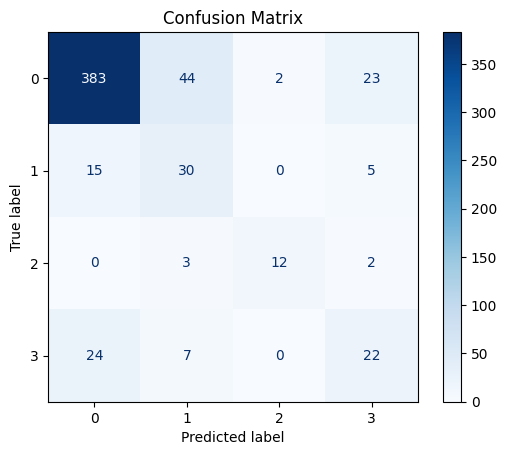

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# # Load the test dataset
# test_dataset = load_from_disk("/kaggle/working/validation_tokenized")

predictions = trainer.predict(validation_tokenized)
final_predictions = np.argmax(predictions.predictions, axis=1)

label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}

prediction_data = []
for gt, pt in zip(validation_tokenized['labels'], final_predictions):
    prediction_data.append([gt, pt])
    
prediction_df = pd.DataFrame(prediction_data, columns=['labels', 'predictions'])
# Convert tensor labels to integers
prediction_df['labels'] = prediction_df['labels'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

report = classification_report(y_true=prediction_df['labels'], y_pred=prediction_df['predictions'])
print(report)

# Confusion matrix
cm = confusion_matrix(y_true= prediction_df['labels'], y_pred= prediction_df['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(prediction_df['labels']))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [25]:
wandb.finish() # Only finish after evaluating

# Saving the best model to hub
trainer.save_model("best_model")
trainer.push_to_hub("Vyke2000/BERT_v3")

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▆▆▃▇▄▆▄▁▂▆▅▇▃▂▄▇██▅▂▄█▄▃█▃▅▂█▄█▄▅▇▄█▇█▇▇
wandb:                 eval/f1 ▂▆▂▄▆▂▄▂▇▆▁▄▆▄▅▄▇▆▂█▆█▆▇▆▆▇▂▄▆▅▂▆▆▆▄▆███
wandb:               eval/loss ▃▂▁▁▁▁▂▂▂▅▄▂▄▁▃▆▅█▄▁▃▆▄▂▆▁▁▄▇▃▇▁▁▆▃▂▂▂▃▂
wandb:          eval/precision ▆▁▄███▅▆▆▂▇▆▁▆▆█▆█▂▁▆▁▂▅▅▆▆█▆▁█▂▇▆█▂▂▅▆▆
wandb:             eval/recall ▃▇▇▃██▄▆▆█▆▇▆▇█▇▅▃▇▇▆▅▆▇▆▅▁▂▅▆▄▇▆▄▇▆▄█▆▅
wandb:            eval/runtime ▃▃▂▅▆▂▃▄▄▃▅▆▆▅▃▅▆▄▆▃█▄▅▁▁▅▆▆▄▄▅▅▄▄▅▄▅▅▄▅
wandb: eval/samples_per_second ▄▇▃▅▂▅▄▄▂▄▅▂▅▄▂▃▁▅▄▄▂▃▃▂▄▃▄▂▄▃▂█▃▇▃▄▄▆▅▂
wandb:   eval/steps_per_second █▆▃▃▄▃▃▃▁▃▅▃▄▂▂▃▆▇▅▁▃▃▁▂▃▄▆▂▂▅▄▅▁▆▃▄▆▆▅▃
wandb:           test/accuracy ▁
wandb:                 test/f1 ▁
wandb:               test/loss ▁
wandb:          test/precision ▁
wandb:             test/recall ▁
wandb:            test/runtime ▁
wandb: test/samples_per_second ▁
wandb:   test/steps_per_second ▁
wandb:             train/epoch ▂▆▇▂▃▆▁▂▅█▄▆██

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Vyke2000/BERT_Classifier_DE/commit/780c3ab40e893c366e169c54f868804c55542d9e', commit_message='Vyke2000/BERT_v3', commit_description='', oid='780c3ab40e893c366e169c54f868804c55542d9e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Vyke2000/BERT_Classifier_DE', endpoint='https://huggingface.co', repo_type='model', repo_id='Vyke2000/BERT_Classifier_DE'), pr_revision=None, pr_num=None)